## Load the environment

---

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ppo_controller import PPOController
from datetime import datetime
import json
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='../Reacher_20/Reacher.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
def rolling_avg_scores(scores, window):
    if len(scores) <= window:
        return [np.mean(scores)]
    else:
        return [np.mean(scores[x:x+window]) for x in range(len(scores) - window + 1)]

def plot_results(scores, surrogates):
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(19, len(scores)), rolling_avg_scores(scores, 20))
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    plt.plot(np.arange(len(surrogates)), surrogates)
    plt.plot(np.arange(19, len(surrogates)), rolling_avg_scores(surrogates, 20))
    plt.ylabel('Surrogate')
    plt.xlabel('Episode #')
    plt.show()

Episode 50/50 | Average Score: 3.35 | Model surrogate: 0.31265 | Divergence: 0.00   

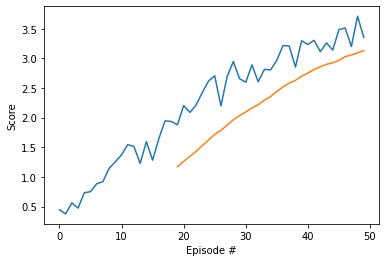

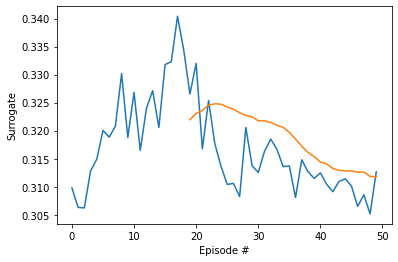

In [4]:
class Config:
    def __init__(self):
        self.num_episodes = 50
        self.epsilon_start = 0.2
        self.beta_start = 1
        self.epsilon_decay =0.999
        self.learning_rate = 5e-4
        self.train_iterations = 10
        self.divergence_target = 0.01
        self.gamma = 0.99
        self.mlp_specs = (200, 150)
        
    def as_dict(self):
        return self.__dict__
    

controller = PPOController(env, brain_name, Config())
scores, surrogates = controller.solve()
plot_results(scores, surrogates)